In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/state-farm-distracted-driver-detection/sample_submission.csv
/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv
/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_96590.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_32366.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_99675.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_85937.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_73903.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_89410.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_70462.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_45622.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_55507.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_34204.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_16279.jpg
/kag

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import seaborn as sns
from PIL import Image
import glob
import pickle
import datetime

2025-05-25 15:06:19.118536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748185579.316573      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748185579.371589      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


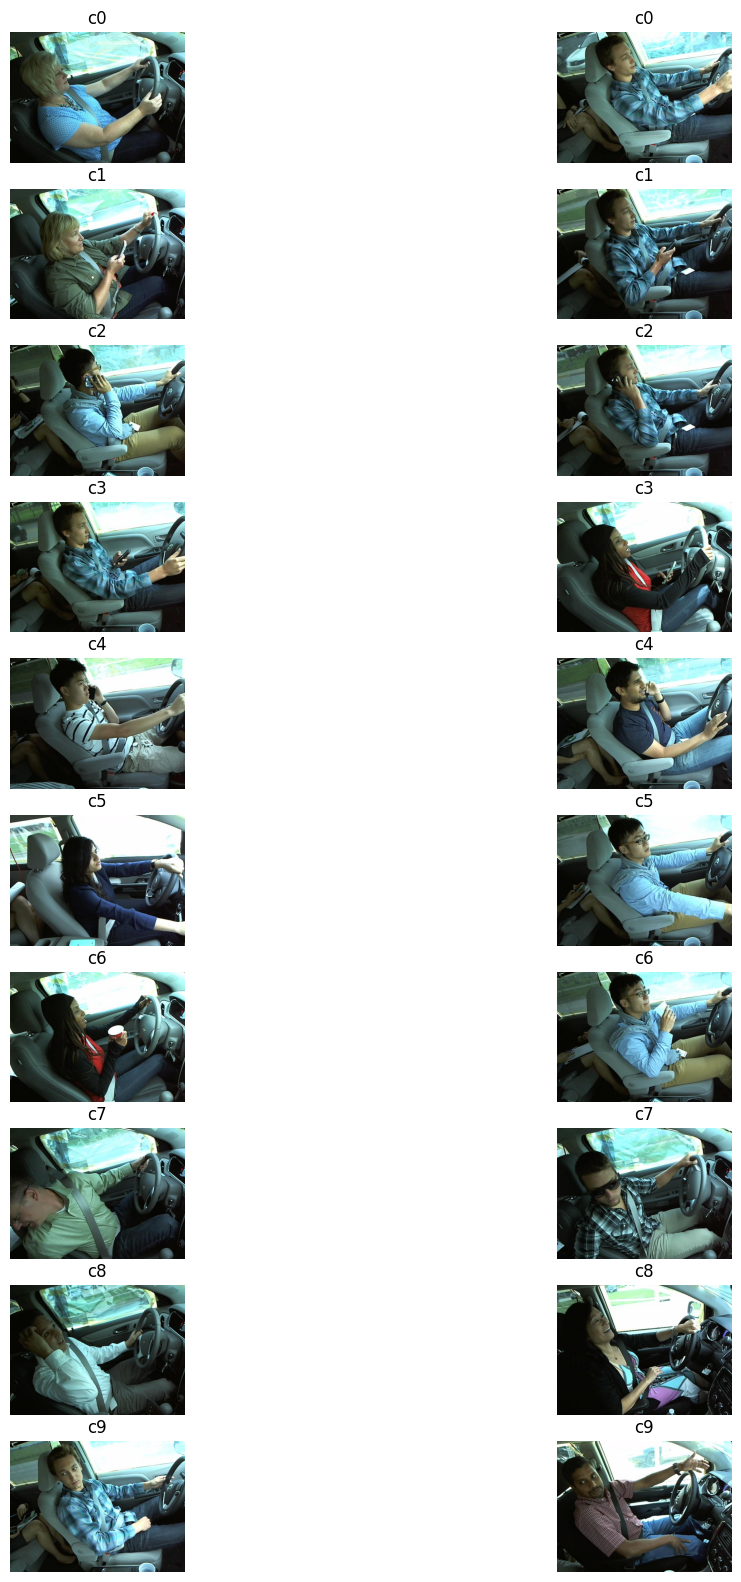

In [3]:
dataset_path = "/kaggle/input/state-farm-distracted-driver-detection/imgs"
TRAIN_DIR = os.path.join(dataset_path, "train")

# Define labels and corresponding classes
labels = {'c0': 'Safe driving',
          'c1': 'Texting - right',
          'c2': 'Talking on the phone - right',
          'c3': 'Texting - left',
          'c4': 'Talking on the phone - left',
          'c5': 'Operating the radio',
          'c6': 'Drinking',
          'c7': 'Reaching behind',
          'c8': 'Hair and makeup',
          'c9': 'Talking to passenger'}
# randomly selecting two images per class
imgs = {}
for label in labels:
    try:
        img_paths = [os.path.join(TRAIN_DIR, label, img_name) for img_name in random.sample(os.listdir(os.path.join(TRAIN_DIR, label)), 2)]
        imgs[label] = [cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) for img_path in img_paths]
    except FileNotFoundError:
        print(f"Directory not found for label: {label}")

# Display the images
display_rows = 10
display_columns = 3
fig = plt.figure(figsize=(20, 20))

for label, index in zip(labels, range(15)):
    for i, img in enumerate(imgs.get(label, [])[:3]):
        fig.add_subplot(display_rows, display_columns, index * 3 + i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(label)

In [4]:
 IMG_SIZE = (224 ,224) # ensures resizing each input image to 64x64 pixels
BATCH_SIZE = 40 

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)

In [17]:
train_data = train_gen.flow_from_directory("/kaggle/input/state-farm-distracted-driver-detection/imgs/train",
                                           target_size=IMG_SIZE,
                                           batch_size=BATCH_SIZE,
                                           subset='training',
                                           seed=42)

Found 17943 images belonging to 10 classes.


In [18]:
val_data = train_gen.flow_from_directory("/kaggle/input/state-farm-distracted-driver-detection/imgs/train",
                                         target_size=IMG_SIZE,
                                         batch_size=BATCH_SIZE,
                                         subset='validation',
                                         seed = 42)

Found 4481 images belonging to 10 classes.


In [31]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = base_model.output
x = Dense(512, activation='relu')(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    verbose=1
)

Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 333s 711ms/step - accuracy: 0.4263 - loss: 2.9700 - val_accuracy: 0.8576 - val_loss: 0.4354
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 290s 647ms/step - accuracy: 0.8545 - loss: 0.4381 - val_accuracy: 0.9188 - val_loss: 0.2583
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 289s 644ms/step - accuracy: 0.9153 - loss: 0.2624 - val_accuracy: 0.9362 - val_loss: 0.1967
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 284s 633ms/step - accuracy: 0.9379 - loss: 0.1916 - val_accuracy: 0.9422 - val_loss: 0.1700
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 282s 629ms/step - accuracy: 0.9506 - loss: 0.1663 - val_accuracy: 0.9638 - val_loss: 0.1194
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 288s 641ms/step - accuracy: 0.9598 - loss: 0.1297 - val_accuracy: 0.9424 - val_loss: 0.1818
Epoch 7/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 281s 626ms/step - accuracy: 0.9691 - loss: 0.1037 - val_accuracy: 0.9460 - val_loss: 0.1590
Epoch 8/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 291s 649ms/step - accuracy: 0.9683 -

In [35]:
model.save('my_model.h5')


In [23]:
!pip freeze > requirements.txt


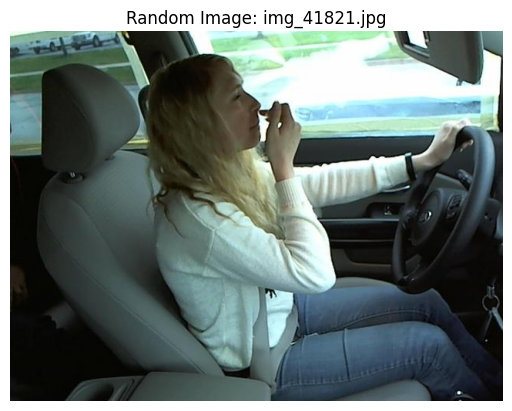

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Hair and makeup


In [68]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tensorflow.keras.models import load_model

# Function to display a random image from a specified directory
def display_random_image(directory):
    # List all files in the directory
    images = os.listdir(directory)

    # Choose a random image file
    random_image = random.choice(images)

    # Construct the full path to the image
    random_image_path = os.path.join(directory, random_image)

    # Display the image
    img = Image.open(random_image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(f'Random Image: {random_image}')
    plt.show()

    return random_image_path

# Function to preprocess the image
def preprocess_image(image_path):
    # Load and preprocess the image
    image = cv2.imread(image_path)  
    image = cv2.resize(image, (224, 224))  
    return image

# Function to predict the class of the image
def predict_image(image_path, model):
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)
    # Expand dimensions to match the model input shape
    input_image = np.expand_dims(preprocessed_image, axis=0)
    # Perform prediction
    prediction = model.predict(input_image)
    # Get the predicted class label
    predicted_class = np.argmax(prediction)
    return predicted_class

# Load the pre-trained CNN model (assuming it's saved as 'driver_dis_model.keras')
model_path = '/kaggle/working/my_model.h5'
driver_dis_model = load_model(model_path)

# Path to the directory containing images
image_directory = "/kaggle/input/state-farm-distracted-driver-detection/imgs/test"

# Display a random image and get its path
random_image_path = display_random_image(image_directory)

# Predict the class of the image using the model
predicted_class = predict_image(random_image_path, driver_dis_model)

# Print the predicted class label
class_labels = {
    0: 'Safe driving',
    1: 'Texting - right',
    2: 'Talking on the phone - right',
    3: 'Texting - left',
    4: 'Talking on the phone - left',
    5: 'Operating the radio',
    6: 'Drinking',
    7: 'Reaching behind',
    8: 'Hair and makeup',
    9: 'Talking to passenger'
}

print("Predicted Class:", class_labels[predicted_class])